In [1]:
import numpy as np
from scipy.optimize import root as solve
from scipy.integrate import quad as integrate
import matplotlib.pyplot as plt

# The single impurity Anderson model

The single impurity Anderson model (SIAM) was proposed by Philip W. Anderson \cite{Anderson1961} to describe the formation of local moments by combining two main ideas from preceding research: Friedel and Blandin's observation \cite{blandin1959} that localized $d$-states form resonances with the electron sea and Peierls and Mott reasoning \cite{MottPeierls} that strong Coulomb repulsion could convert a metal into an insulator. This is captured by the Hamiltonian:
\begin{align}
	H_{SIAM} &= H_{con} + H_{imp} + H_{hyb} ~,\\
	H_{con} &= \sum_{k,\sigma}\epsilon_{k}c_{k\sigma}^{\dagger}c_{k\sigma} ~,\\
	H_{imp} &= \sum_{m,\sigma}\epsilon_{m}d_{m\sigma}^{\dagger}d_{m\sigma} +
    \frac{1}{2}\sum_{\substack{m,m^{\prime}m^{\prime\prime}m^{\prime\prime\prime} \\ \sigma\sigma^{\prime}}}
    U_{mm^{\prime}m^{\prime\prime}m^{\prime\prime\prime}}d_{m\sigma}^{\dagger}d_{m^{\prime}\sigma^{\prime}}^{\dagger}d_{m^{\prime\prime\prime}\sigma^{\prime}} d_{m^{\prime\prime}\sigma} ~,\\
	H_{hyb} &= \sum_{k,m,\sigma}\left(V_{k m}c_{k\sigma}^{\dagger}d_{m\sigma}+\operatorname{h.c}\right)~,
    \end{align}
where $H_{con}$ describes conduction electrons, $H_{imp}$ local electrons and $H_{hybr}$ the hybridization between these.

In [2]:
def nFermi (w, invT):
  """ 
      Fermi distribution function
      beta = `invT`
  """
  return 0.5 * ( 1.0 - np.tanh(0.5 * invT * w) )

## Mean-field theory


A traditional starting point for the analysis of interactions in many-electron systems is the mean-field theory; here many-body correlations are treated as a mean density (or field). In this procedure, the correlations are "averaged", leaving a solvable, single-particle problem.

Even though mean-field theory is a powerful tool, one must be very aware of its limitations. To achieve a correct description of strongly correlated systems, many-body correlations cannot be averaged, as this washes out crucial underlying dynamics.

The fundamental deficiency of the Anderson model mean-field (Hartree-Fock approximation) is that it leads to a broken spin symmetry. The approximation misses quantum fluctuations between the mean-field solutions, a process intrinsic to the Kondo effect that effectively restores the spin-rotational symmetry. A single impurity cannot lead to a magnetic solution; correspondingly, the mean-field solution cannot explain the singlet ground state known from the exact Bethe ansatz solution
\cite{Andrei1980}.

## Single orbital solutions
$\newcommand{\dx}[1]{ \mathrm{d}{#1} \,}$

By only considering one local orbital, the hybridization $\Delta^{\sigma \sigma^{\prime}}_{m m^{\prime}}\left(i\omega_n\right)$ reduces to
\begin{equation}
	\Delta^{\sigma \sigma^{\prime}}_{m m^{\prime}}\left(i\omega_n\right) \rightarrow
    \sum_{k}\frac{V^2_k}{i\omega_n - \epsilon_k}~.
\end{equation}
For simplicity, we ignore the momentum dependence of the hybridization. Performing an analytic continuation $i\omega_n\rightarrow\omega-i0^+$ and replacing the sum over $k$ by an integral over the density of states $\rho$, we obtain an expression for $\Delta\left(\omega-i0^+\right)$
\begin{equation}
	\Delta\left(\omega-i0^+\right) = \sum_k \frac{V^2}{\omega-\epsilon_k - i 0^+} =
    \int \dx{\epsilon} \rho\left(\epsilon\right) \frac{V^2}{\omega - \epsilon - i 0^+} = 
    \int \dx{\epsilon} \frac{\pi\rho\left(\epsilon\right) V^2}{\pi} \frac{1}{\omega - \epsilon - i 0^+}~.
\end{equation}
Defining $\pi\rho\left(\epsilon\right) V^2 \equiv \bar{\Delta}\left(\epsilon\right)$ and assuming a constant $\bar{\Delta}\left(\epsilon\right)$ inside the bandwidth, i.e., $\epsilon\in \left[-D,D\right]$
\begin{equation}
	\Delta\left(\omega - i0^+\right) = \frac{\bar{\Delta}}{\pi} \log\left[\frac{\omega + D - i 0^+}{\omega - D - i 0^+}\right] = 
    \frac{\bar{\Delta}}{\pi} \log\left[\frac{\omega/D + 1 - i0^+}{\omega/D - 1 - i0^+}\right] =
    i \bar{\Delta} + \mathcal{O}\left(\omega/D\right)~.
\end{equation}
Relabeling $\Delta\rightarrow \bar{\Delta}$, the mean-field equations reduce to
\begin{equation}
	\left\langle n_{d_{\sigma}}\right\rangle = \frac{1}{\pi} \int_{-\infty}^{+\infty} \dx{\omega}
    n_f\left(\omega\right)\frac{\Delta}{\left[\omega - \left(\epsilon_d +
    	U \left\langle n_{d_{\bar{\sigma}}}\right\rangle \right)\right]^2+\Delta^2}~.
\end{equation}

Taking the broad bandwidth $D\rightarrow \infty$ and zero-temperature $T\rightarrow0$ limits, one arrives at the same set of equations Anderson derived in his seminal work \cite{Anderson1961} that qualitatively explained the experimentally observed formation of local moments
\begin{equation}
	\left\langle n_{f_{\sigma}}\right\rangle = \frac{1}{\pi}
    	\cot^{-1}\left(\frac{\epsilon_f + U \left\langle n_{f_{\bar{\sigma}}}\right\rangle}{\Delta}\right)~,
\end{equation}
for which he determined an approximate condition for moment formation
\begin{equation}
	U \geq \pi\,\Delta~.
\end{equation}

In [3]:
def eqs(n0, params):
    '''
        Anderson mean-field equations for finite non-zero temperature.

        Normalize by \Delta, obtaining the following integrand:
            1/\pi n_f(\omega) \frac{1}{1 + (x + y n_)^2}

        n0 = [n0_up, n0_down]
    '''

    bounds = {'a': -np.inf, 'b': np.inf}

    invT = params['invT']

    c_up = params['x'] - params['y'] * n0[1]
    n_up = 1 / np.pi * \
        integrate(func=lambda w: nFermi(w, invT) /
                  (1 + (w + c_up)**2), **bounds)[0]

    c_dw = params['x'] - params['y'] * n0[0]
    n_dw = 1 / np.pi * \
        integrate(func=lambda w: nFermi(w, invT) /
                  (1 + (w + c_dw)**2), **bounds)[0]

    # return residual
    return [n_up, n_dw] - n0

## Mean-field phase diagram

In [4]:
params = {'invT': np.nan, 'x': np.nan, 'y': np.nan}

# parameter scan settings
params['invT'] = 1e4
ax_X = np.linspace(0, 10.0, num=100)
ax_Y = np.linspace(0, 10.0, num=100)

# solution vector
magnetization = np.zeros([len(ax_X), len(ax_Y)])

# scan parameters region
for i, x in enumerate(ax_X):
    for j, y in enumerate(ax_Y):
        params['x'] = x
        params['y'] = y
        
        # it's advisable to have asymetric trial solutions
        sol = solve(eqs, x0=[0.9, 0.2], args=params).x
        
        magnetization[i,j] = sol[0] - sol[1]

# chop solution
magnetization[np.abs(magnetization) < 1e-8] = 0

<IPython.core.display.Javascript object>


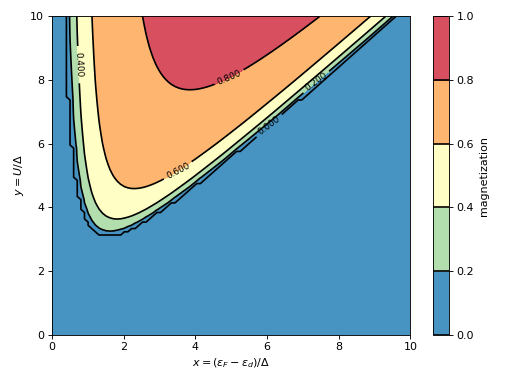

In [11]:
%matplotlib notebook
%matplotlib notebook

# fancy plotting
base = plt.contourf(ax_X, ax_Y, magnetization.T, 4, cmap = 'Spectral_r', alpha=0.90)
line = plt.contour (ax_X, ax_Y, magnetization.T, levels = base.levels, colors='black', linewidth=0.5)
plt.xlabel(r'$ x = (\varepsilon_F - \varepsilon_d) / \Delta $')
plt.ylabel(r'$ y = U / \Delta $')
plt.clabel(line, inline=1, fontsize=8)
bar = plt.colorbar(base)
bar.add_lines(line)
bar.ax.set_ylabel("magnetization")
plt.tight_layout()

The solution shows a competition effect between the Coulomb interaction and hybridization
The magnetization is defined as $\left\langle n_{f_{\uparrow}} \right\rangle - \left\langle n_{f_{\downarrow}} \right\rangle$. Two asymptotic limits can be identified in this mean-field description:
* The atomic limit, when the Coulomb interaction $U$ wins over the hybridization and impedes the double occupation of the impurity level. At this limit, the ground state corresponds to a singly occupied impurity. At low temperatures/energies, the interaction of this local moment with the conduction sea gives rise to the Kondo effect: a many-body spin-singlet state is formed, as the moment is screened dynamically by conduction sea;
* The unpolarized limit, when $\left\langle n_{d_{\uparrow}} \right\rangle = \left\langle n_{d_{\downarrow}} \right\rangle = \frac{1}{2} n_d$. The Coulomb interaction is on average relatively small and the impurity has equal probability of being occupied, with a spin-up and spin-down electron. The ground state is a paramagnetic Fermi liquid.

Increasing the temperature would change the phase diagram since it would allow increasingly equal average occupations of the split spin-up and spin-down resonances. Forming a local moment will consequently require a larger splitting between the spin-up and spin-down resonances, which will push the atomic limit island upwards and flatten its tip.
